In [1]:
from __future__ import division
%pylab inline
import numpy as np
import scipy.spatial.distance as dist
from scipy import stats
import pickle
import math
import collections
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
# " " = high   =  1
# "%" = low    =  0
# len(row) = 10
def countNum(name = "yes_train.txt"):
    with open(name) as dataset:
        num_lines = sum(1 for line in dataset)
        return num_lines / 28
    


for training 

In [3]:
# label yes = 1
# label no = 0
Num_sample_yes =  countNum()
Num_sample_no =  countNum("no_train.txt")
print(Num_sample_yes,Num_sample_no)

140.0 131.0


In [4]:
Num_test_yes =  countNum("yes_test.txt")
Num_test_no =  countNum("no_test.txt")
print(Num_test_yes,Num_test_no)

50.0 50.0


In [5]:
def inputDigit(name="yes_train.txt"):
    with open(name) as digitTxt:
        image = [list(line)[0:10] for line in digitTxt]
    return image

In [6]:
data_yes = inputDigit()
data_no = inputDigit("no_train.txt")
test_yes = inputDigit("yes_test.txt")
test_no = inputDigit("no_test.txt")

In [45]:
#   yes is class 0
#   no is class 1
k = 3.3
    
def training(yes_train, no_train, yes_num, no_num):
    # " " = high   =  1
    # "%" = low    =  0
    
    class_total = [yes_num, no_num]

    training0 = np.zeros(shape=(2, 25, 10))   #high
    training1 = np.zeros(shape=(2, 25, 10))   #low

    count = 0
    for i in range(int(yes_num)):
        for row in range(25):
            for col in range(10):
                if yes_train[i*28 + row][col] == ' ':      # offset = i*28, since 25 + 3(blank rows)
                    training1[0][row][col] += 1
                else:
                    training0[0][row][col] += 1
                    
    for i in range(int(no_num)):
        for row in range(25):
            for col in range(10):
                if no_train[i*28 + row][col] == ' ':
                    training1[1][row][col] += 1
                else:
                    training0[1][row][col] += 1

    # laplace smooth
    for i in range(2):
        training1[i] = (training1[i] + k) / (class_total[i] + k * 2)
        
        training0[i] = (training0[i] + k) / (class_total[i] + k * 2)
#     print(training0[1][0])
#     print(training1[1][0])
    return training0, training1

In [46]:
training0, training1 = training(data_yes, data_no, Num_sample_yes, Num_sample_no)

In [47]:
# log P(class) + log P(f1,1 | class) + log P(f1,2 | class) + ... + log P(f28,28 | class)

# test_rough = inputDigit(name = "digitdata/testimages")
def testing(yes_test, no_test, Num_test_yes, Num_test_no):

    data_test = np.concatenate( (yes_test, no_test) , axis = 0 )
# #     print len(data_test) / 28
#     return 

    total = Num_test_yes + Num_test_no
    answer = np.zeros(int(total))
    
    class_total = [Num_test_yes, Num_test_no]
    
    for i in range(int(total)):
        test_image = np.zeros(shape=(25,10))
        for row in range(25):
            for col in range(10):
                if data_test[i*28+row][col] == ' ':
                    test_image[row][col] = 1
                else:
                    test_image[row][col] = 0
                    

        posteriori = np.zeros(2)
        for class_num in range(2):
            posteriori[class_num] = math.log(class_total[class_num])
            for row in range(25):
                for col in range(10):
                    if test_image[row][col] == 0:
                        posteriori[class_num] += math.log(training0[class_num][row][col])
                    else:
                        posteriori[class_num] += math.log(training1[class_num][row][col] )   
        answer[i] = np.argmax(posteriori)

    return answer

In [48]:
answer = testing(test_yes, test_no, Num_test_yes, Num_test_no)

In [49]:
def confusion_matrix(pred):
    conf_matrix = np.zeros(shape=(2,2))
    #print(conf_matrix[0][0])
    #print(int(answer[0]))
    for i in range(100):
        if i < 50:
            conf_matrix[0][int(pred[i])] += 1
        else:
            conf_matrix[1][int(pred[i])] += 1
            
    for i in range(2):
        for j in range(2):
            conf_matrix[i][j] /= 50.0
    
    return conf_matrix

In [50]:
# print confusion matrix
conf_matrix = confusion_matrix(answer)
conf_matrix = np.around(conf_matrix, 2)
for row in conf_matrix:
    print(row)
overall_accuracy = 0
for i in range(2):
    overall_accuracy += conf_matrix[i][i] * 50.0
print("overall_accuracy = " + str(overall_accuracy/100))

[ 0.98  0.02]
[ 0.04  0.96]
overall_accuracy = 0.97


# Now, let's find the best k##

In [43]:
# Laplace smoothing constant
k1 = np.array([10**(-6), 10**(-5), 10**(-4), 0.001, 0.002, 0.005, 0.01, 0.02, 0.05])
k2 = np.linspace(0.1, 10, 100)
k_grid = np.append(k1, k2)

accuracy = np.zeros(109)

for k_index in range(109):
    k = k_grid[k_index]
    #print(k)
    training0, training1 = training(data_yes, data_no, Num_sample_yes, Num_sample_no)
    answer = testing(test_yes, test_no, Num_test_yes, Num_test_no)
    conf_matrix = confusion_matrix(answer)
    overall_accuracy = 0
    for i in range(2):
        overall_accuracy += conf_matrix[i][i] * 50.0
        accuracy[k_index] = overall_accuracy
    print("accuracy =", overall_accuracy/100.0, "when k is ", k_grid[k_index])

accuracy = 0.95 when k is  1e-06
accuracy = 0.95 when k is  1e-05
accuracy = 0.95 when k is  0.0001
accuracy = 0.96 when k is  0.001
accuracy = 0.96 when k is  0.002
accuracy = 0.96 when k is  0.005
accuracy = 0.96 when k is  0.01
accuracy = 0.96 when k is  0.02
accuracy = 0.96 when k is  0.05
accuracy = 0.96 when k is  0.1
accuracy = 0.96 when k is  0.2
accuracy = 0.96 when k is  0.3
accuracy = 0.96 when k is  0.4
accuracy = 0.96 when k is  0.5
accuracy = 0.96 when k is  0.6
accuracy = 0.96 when k is  0.7
accuracy = 0.96 when k is  0.8
accuracy = 0.96 when k is  0.9
accuracy = 0.96 when k is  1.0
accuracy = 0.96 when k is  1.1
accuracy = 0.96 when k is  1.2
accuracy = 0.96 when k is  1.3
accuracy = 0.96 when k is  1.4
accuracy = 0.96 when k is  1.5
accuracy = 0.96 when k is  1.6
accuracy = 0.96 when k is  1.7
accuracy = 0.96 when k is  1.8
accuracy = 0.96 when k is  1.9
accuracy = 0.96 when k is  2.0
accuracy = 0.96 when k is  2.1
accuracy = 0.96 when k is  2.2
accuracy = 0.96 when k 

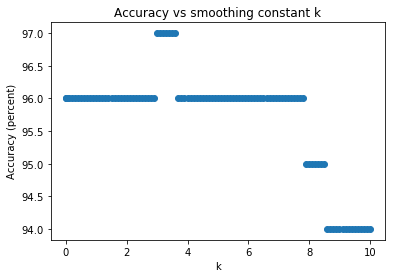

In [34]:
%matplotlib inline
plt.figure()
ax = plt.gca()
#ax.set_xscale('log')
plt.scatter(k_grid[5:], accuracy[5:], label = 'f(x)')
plt.xlabel("k")
plt.ylabel("Accuracy (percent)")
plt.title("Accuracy vs smoothing constant k")

In [30]:
# Laplace smoothing constant
k_grid = np.linspace(3.0, 3.6, 60)

accuracy = np.zeros(60)

for k_index in range(60):
    k = k_grid[k_index]
    #print(k)
    training0, training1 = training(data_yes, data_no, Num_sample_yes, Num_sample_no)
    answer = testing(test_yes, test_no, Num_test_yes, Num_test_no)
    conf_matrix = confusion_matrix(answer)
    overall_accuracy = 0
    for i in range(2):
        overall_accuracy += conf_matrix[i][i] * 50
        accuracy[k_index] = overall_accuracy
    print("accuracy =", overall_accuracy/100, "when k is ", k_grid[k_index])

accuracy = 0.97 when k is  3.0
accuracy = 0.97 when k is  3.01016949153
accuracy = 0.97 when k is  3.02033898305
accuracy = 0.97 when k is  3.03050847458
accuracy = 0.97 when k is  3.0406779661
accuracy = 0.97 when k is  3.05084745763
accuracy = 0.97 when k is  3.06101694915
accuracy = 0.97 when k is  3.07118644068
accuracy = 0.97 when k is  3.0813559322
accuracy = 0.97 when k is  3.09152542373
accuracy = 0.97 when k is  3.10169491525
accuracy = 0.97 when k is  3.11186440678
accuracy = 0.97 when k is  3.12203389831
accuracy = 0.97 when k is  3.13220338983
accuracy = 0.97 when k is  3.14237288136
accuracy = 0.97 when k is  3.15254237288
accuracy = 0.97 when k is  3.16271186441
accuracy = 0.97 when k is  3.17288135593
accuracy = 0.97 when k is  3.18305084746
accuracy = 0.97 when k is  3.19322033898
accuracy = 0.97 when k is  3.20338983051
accuracy = 0.97 when k is  3.21355932203
accuracy = 0.97 when k is  3.22372881356
accuracy = 0.97 when k is  3.23389830508
accuracy = 0.97 when k is  3